# License

    Jupyter notebook for accessing CUDA
    Copyright (C) 2018 Andre.Brodtkorb@ifi.uio.no

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>.

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

#Import packages we need
import numpy as np
import pycuda.compiler as cuda_compiler
from pycuda.gpuarray import GPUArray
import pycuda.driver as cuda_driver

from matplotlib import pyplot as plt

In [2]:
#Initialize CUDA - must be first call to CUDA!
cuda_driver.init()

In [3]:
#Create CUDA context
cuda_device = cuda_driver.Device(0)
print("Using '{:s}'".format(cuda_device.name()))
print(" => compute capability: {:s}".format(str(cuda_device.compute_capability())))
context = cuda_device.make_context()
free, total = cuda_driver.mem_get_info()
print(" => memory: {:d} / {:d} MB available".format(int(free/(1024*1024)), int(total/(1024*1024))))

Using 'Tesla K80'
 => compute capability: (3, 7)
 => memory: 9188 / 11441 MB available


In [4]:
cuda_kernel = """
__global__ void addVexKernel(float* c, float* a, float* b) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    c[i] = a[i] + b[i];
}

__global__ void addMatrixKernel( float * c, float* a, float* b, int cols) {
    unsigned int i = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    unsigned int k = j*cols + i;
    
    c[k] = a[k] + b[k];
}

"""
module = cuda_compiler.SourceModule(cuda_kernel)
kernel = module.get_function("addMatrixKernel");

In [5]:
#Size of our test
test_size = (16, 24)

#Create test input / output data
a = np.random.random(test_size).astype(np.float32)
b = np.random.random(test_size).astype(np.float32)
c = np.empty_like(a)

In [6]:
print( a.shape)

(16, 24)


In [7]:
#Upload data to the device
a_g = GPUArray(a.shape, np.float32)
b_g = GPUArray(b.shape, np.float32)
a_g.set(a)
b_g.set(b)

In [8]:
#Allocate output data
c_g = GPUArray(c.shape, np.float32)

In [9]:
#a.shape = [rows, columns] => [y, x]
domain_size = (a.shape[1],a.shape[0])
block_size = ( 8, 4, 1) # According to a.shape this must be [x, y, z]
grid_size = ( domain_size[0] // block_size[0], domain_size[1] // block_size[1] ,1 )

print("Domain size is " + str(domain_size))
print("Block size is " + str(block_size))
print("Grid size is " + str(grid_size))

Domain size is (24, 16)
Block size is (8, 4, 1)
Grid size is (3, 4, 1)


In [10]:
#Execute program on device
kernel(c_g, a_g, b_g, np.int32(domain_size[0]), block=block_size, grid=grid_size)

#Copy data from device to host
c_g.get(c)

array([[1.052519  , 1.3274565 , 0.694355  , 1.2158697 , 0.7625821 ,
        1.4108863 , 0.73737216, 1.3842227 , 1.0883455 , 1.0969968 ,
        1.2026778 , 1.261967  , 0.9755929 , 0.89051557, 1.6308345 ,
        0.75818956, 1.371532  , 1.2241049 , 1.13711   , 1.0018773 ,
        0.8074315 , 0.3075932 , 1.5765162 , 0.68019396],
       [0.39808917, 0.73721623, 0.5366184 , 1.0598495 , 1.1273406 ,
        0.9873525 , 0.7767452 , 1.5952218 , 1.1370995 , 0.8571677 ,
        0.68151265, 1.5259459 , 0.59920526, 0.75153965, 1.7631935 ,
        1.5366048 , 0.6753411 , 1.1487643 , 0.6548003 , 1.0733061 ,
        1.346602  , 0.8006703 , 0.21804464, 1.3449914 ],
       [0.92938066, 1.0121052 , 1.7263417 , 0.9368596 , 1.7236817 ,
        0.7873632 , 0.67020243, 0.47403288, 0.98922044, 1.3900968 ,
        1.7346913 , 1.7134526 , 0.93775994, 0.7522258 , 0.32346243,
        1.2300851 , 0.93458587, 0.31986248, 1.1347241 , 0.7614744 ,
        0.40409794, 1.7801862 , 1.1284416 , 1.0582653 ],
       [0.182

In [11]:
#Compute reference using Numpy
c_ref = a + b

#Print result
print("C   = ", c)
print("Ref = ", c_ref)
print("Sad = ", np.sum(np.abs(c - c_ref)))

C   =  [[1.052519   1.3274565  0.694355   1.2158697  0.7625821  1.4108863
  0.73737216 1.3842227  1.0883455  1.0969968  1.2026778  1.261967
  0.9755929  0.89051557 1.6308345  0.75818956 1.371532   1.2241049
  1.13711    1.0018773  0.8074315  0.3075932  1.5765162  0.68019396]
 [0.39808917 0.73721623 0.5366184  1.0598495  1.1273406  0.9873525
  0.7767452  1.5952218  1.1370995  0.8571677  0.68151265 1.5259459
  0.59920526 0.75153965 1.7631935  1.5366048  0.6753411  1.1487643
  0.6548003  1.0733061  1.346602   0.8006703  0.21804464 1.3449914 ]
 [0.92938066 1.0121052  1.7263417  0.9368596  1.7236817  0.7873632
  0.67020243 0.47403288 0.98922044 1.3900968  1.7346913  1.7134526
  0.93775994 0.7522258  0.32346243 1.2300851  0.93458587 0.31986248
  1.1347241  0.7614744  0.40409794 1.7801862  1.1284416  1.0582653 ]
 [0.18206131 0.705739   0.42537823 0.38349542 0.6691088  0.872277
  1.0476612  0.95975226 0.7583407  1.2165741  1.4324582  0.8725616
  1.2904658  0.34303683 1.1911097  1.7778583  1.34

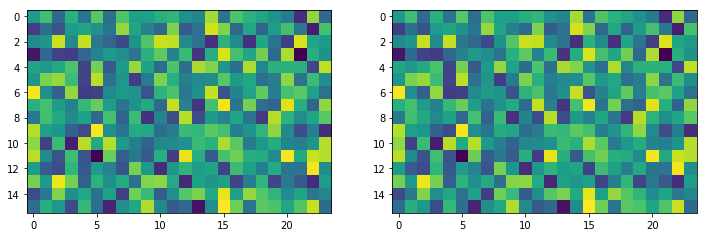

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(c)
plt.subplot(1,2,2)
plt.imshow(c_ref)